In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-03-26 22:08
@Project  :   Hands-on Deep Learning with PyTorch-xavier_and_kaiming_weight_initialization
Xavier与Kaiming参数初始化
'''

# 导入所需的库
import torch
from matplotlib import pyplot as plt
from torch import nn

from layers.linears import L2SigmoidLR, L4SigmoidLR, L3TanhLR, L3ReLULR
from utils.data_gen_split import gen_reg_data, split_load_data
from utils.datasets import GenDataset
from utils.train_utils import compare_models
from utils.visualization_utils import violin_plot_layers

# 设置随机种子
torch.manual_seed(3272315)

参数的初始化方法主要从以下几个角度进行考虑：
1. 为了满足或者更好的满足Glorot条件
2. 数学理论推导出参数方差
3. 方差由扇入和扇出神经元个数组成

主流的参数初始化方法有Xavier方法和Kaiming方法等。
## 1.Xavier初始化参数方法
### Xavier方法基础理论
Glorot条件的核心是正向传播时候数据流经每一层前后的方差一致，并且反向传播时候数据流经每一层时的前后梯度方差一致。前者称为向前传播条件，后者称为反向传播条件。
当前向传播条件成立的时候，经过公式推导和合理假设，得到：
$$Var(z) = nVar(w)Var(x)$$
其中，z是当前层接收到的数据、x是上一层的输出、w代表线性层权重、n是上一层神经元的个数，因为期望线性变换不改变方差，因此有：
$$Var(z)=Var(x)$$
所以有：
$$Var(w) = \frac{1}{n}$$
反向传播与正向传播正好相反，反向传播时z代表上一层神经元接收到的数据，而x则代表当前层传出的数据，n的含义却发生了变化，n是当前层的神经元个数。为了进行区分，我们将正向传播时的n、也就是代表上一层神经元个数的变量，命名为$n_{in}$（也称为扇入fan in），而在进行反向传播时的n、也就是代表当前层神经元个数的变量，命名为$n_{out}$（也称为扇出fan out）。为了同时兼顾向前传播和反向传播这两种情况，将w的最终方差进行折中，取值为：
$$Var(w) = \frac{1}{\frac{n_{in}+n_{out}}{2}} = \frac{2}{n_{in}+n_{out}}$$
（1）如果假设w服从均匀在[-a, a]区间内均匀分布，则w的方差为：$Var(w) = \frac{(a+a)^2}{12} = \frac{4a^2}{12} = \frac{a^2}{3} = \frac{2}{n_{in}+n_{out}}$
计算得：$a = \sqrt{\frac{6}{n_{in}+n_{out}}}$，即w是分布在$(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}})$上的均匀随机变量。
（2）如果假设w是服从正态分布，则w是服从$(0, \sqrt{\frac{2}{n_{in}+n_{out}}})$的随机变量。
据此，我们就能设置每一层的初始参数，PyTorch提供了init方法进行初始化。
### Xavier方法实现均匀分布的参数初始化
用`torch.nn.init.xavier_uniform_`进行Xavier方法的参数均匀分布初始化。该函数处理的对象是张量，$fan_{in}$由张量的列决定、$fan_{out}$由张量的行数决定（这与PyTorch中线性层权重是一般意义的权重矩阵的转置特性有关）。公式为：
$$a = \text{gain} \times \sqrt{\frac{6}{\text{fan_in} + \text{fan_out}}}$$
其中gain为增益系数，用于手动调整均匀分布的边界，默认调整。

In [2]:
# 测试xavier_uniform_
weight = torch.randint(1, 21, (2, 4), dtype=torch.float)
print(weight)
nn.init.xavier_uniform_(weight)  # 原地修改，分母是4+2=6，所以分布区间是(-1, 1)

tensor([[13., 13.,  6., 10.],
        [ 8., 14., 13., 11.]])


tensor([[-0.2744, -0.9246,  0.2919,  0.6316],
        [-0.8013, -0.0441,  0.2760,  0.0155]])

#### Sigmoid激活函数

In [3]:
# 创建数据
features, labels = gen_reg_data(w=(2, -1), bias=False, deg=2)
labels.unsqueeze_(-1)

# 数据切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1f36f797b80>,
 <torch.utils.data.dataloader.DataLoader at 0x1f36f797b50>)

In [4]:
# 设置超参数
lr = 0.03
num_epochs = 20

# 实例化模型
sigmoid_lr_l2_normal = L2SigmoidLR()  # 不进行初始化
sigmoid_lr_l2_init = L2SigmoidLR()  # 进行初始化

# Xavier初始化模型参数
for module in sigmoid_lr_l2_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 模型和名称列表
model_list = [sigmoid_lr_l2_normal, sigmoid_lr_l2_init]
name_list = ['sigmoid_lr_l2_normal', 'sigmoid_lr_l2_init']
model_list

[L2SigmoidLR(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=1, bias=True)
 ),
 L2SigmoidLR(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=1, bias=True)
 )]

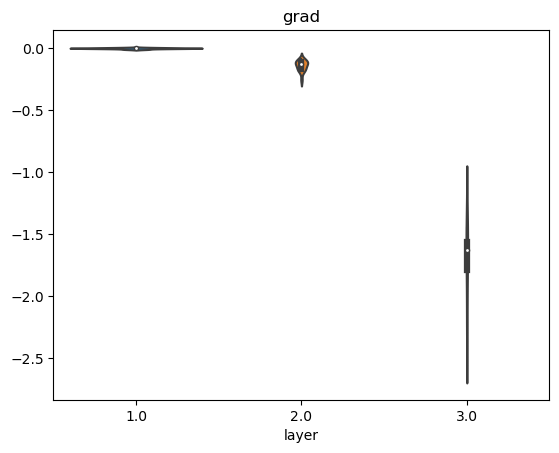

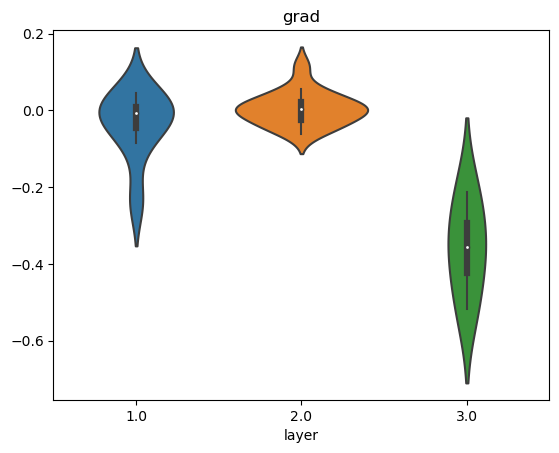

In [5]:
# 开始训练
compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=1)

# 绘制两个模型的梯度小提琴图
violin_plot_layers(sigmoid_lr_l2_normal)
violin_plot_layers(sigmoid_lr_l2_init)

可以看到，在只迭代了1轮时，经过Xavier初始化的模型梯度整体更加稳定，并且没有出现明显的梯度消失，但是原始模型第1层的梯度已经非常小了，已经出现了严重的梯度消失的倾向。因为各层梯度的情况就代表着模型学习的状态，很明显经过初始化的模型各层基本都处于平稳学习状态，此时模型收敛速度较快。也可以通过MSE曲线进行验证。

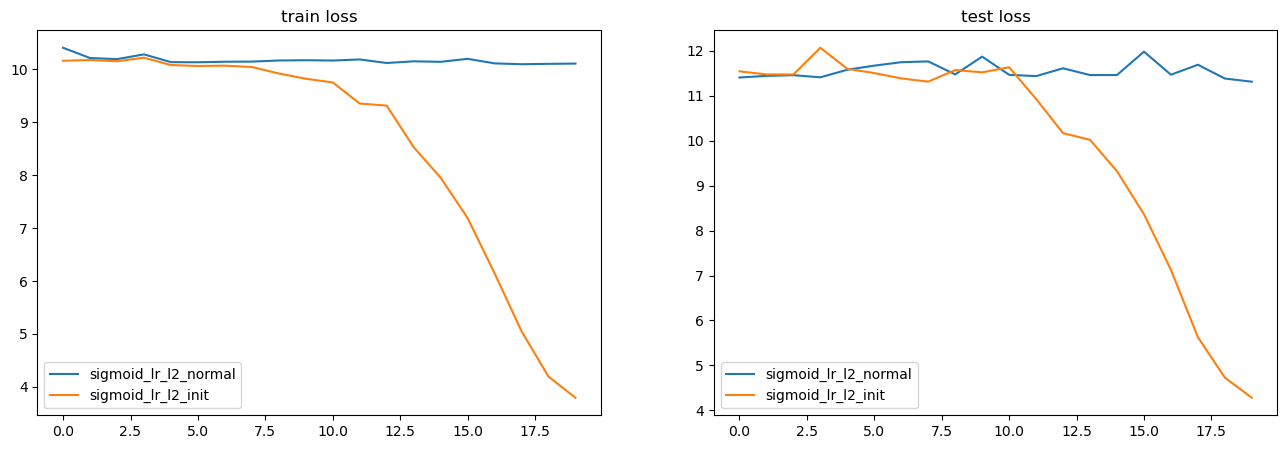

In [6]:
# 继续迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 经过Xavier初始化的模型收敛更快

可以看到，Xavier初始化的作用核心在于保证各层梯度取值的平稳分布，从而确保各层模型学习的有效性，最终在模型结果的表现上，经过Xavier初始化参数的模型学习效率更高、收敛速度更快。在一些更极端的情况下，Xavier方法的初始化方法效果会更加明显。
以4层Sigmoid隐藏层的神经网络为例，进一步观察Xavier初始化在规避梯度消失问题时的效果。

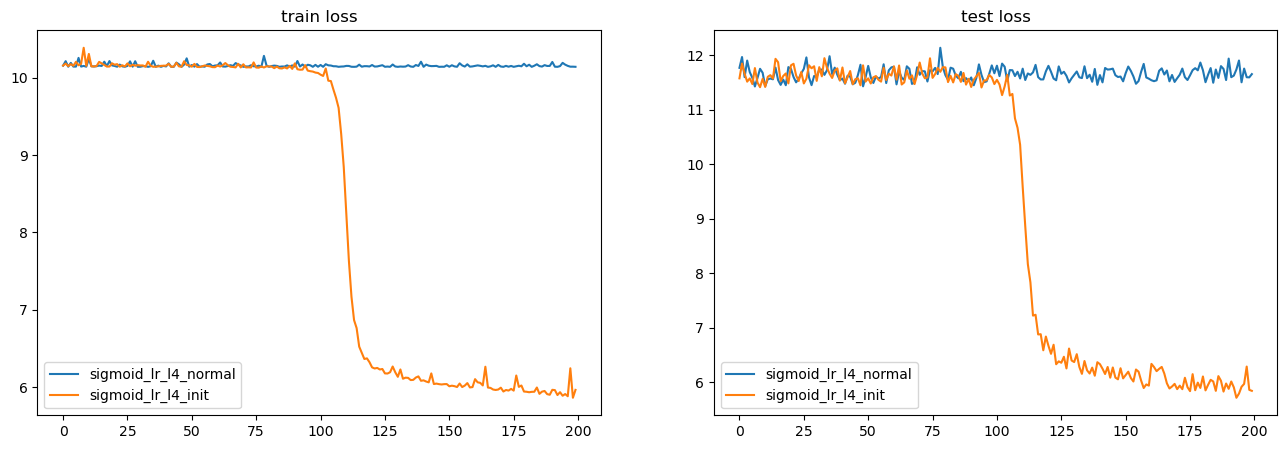

In [7]:
# 实例化模型
sigmoid_lr_l4_normal = L4SigmoidLR()
sigmoid_lr_l4_init = L4SigmoidLR()

# 使用Xavier方法初始化权重
for module in sigmoid_lr_l4_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 模型列表
model_list = [sigmoid_lr_l4_normal, sigmoid_lr_l4_init]
name_list = ['sigmoid_lr_l4_normal', 'sigmoid_lr_l4_init']

# 设置超参数
lr = 0.03
num_epochs = 200

train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

可以看到，不经过Xavier方法初始化的包含4层Sigmoid的模型出现了严重的梯度消失，由于前几层基本丧失学习能力，模型本身效果并不好。但加入Xavier初始化之后，经过权重初始化的模型能够极大程度规避梯度消失问题，从而能够加快收敛、并获得更好的效果。
### Tanh激活函数
同时，相比于Sigmoid激活函数，Xavier初始化方法更适用于Tanh激活函数，核心原因在于Tanh激活函数本身能够生成Zero-centered Data，配合Xavier初始化生成的参数，能够更好的确保各层梯度平稳、确保各层平稳学习。先对2层Tanh模型进行Xavier初始化，分析Xavier初始化的效果。

In [8]:
# 实例化模型
tanh_lr_l3_normal = L3TanhLR()
tanh_lr_l3_init = L3TanhLR()

# 模型参数初始化
for module in tanh_lr_l3_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 模型列表
model_list = [tanh_lr_l3_normal, tanh_lr_l3_init]
name_list = ['tanh_lr_l3_normal', 'tanh_lr_l3_init']
model_list

[L3TanhLR(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=4, bias=True)
   (linear4): Linear(in_features=4, out_features=1, bias=True)
 ),
 L3TanhLR(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=4, bias=True)
   (linear4): Linear(in_features=4, out_features=1, bias=True)
 )]

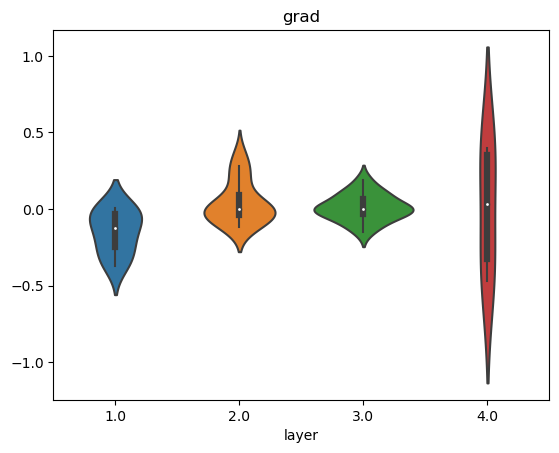

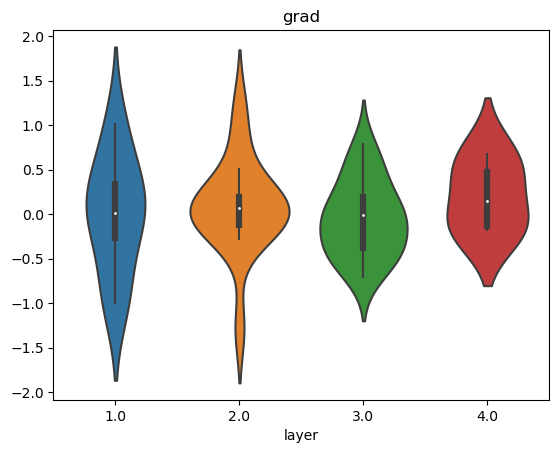

In [9]:
# 模型训练
compare_models(model_list, train_loader, test_loader, num_epochs=1)

# 绘制两个模型梯度的小提琴图
violin_plot_layers(tanh_lr_l3_normal)
violin_plot_layers(tanh_lr_l3_init)  # 经过Xavier参数初始化后的模型梯度更加平稳、梯度爆炸的可能降低，可以推测经过初始化之后的模型初始迭代时收敛更快

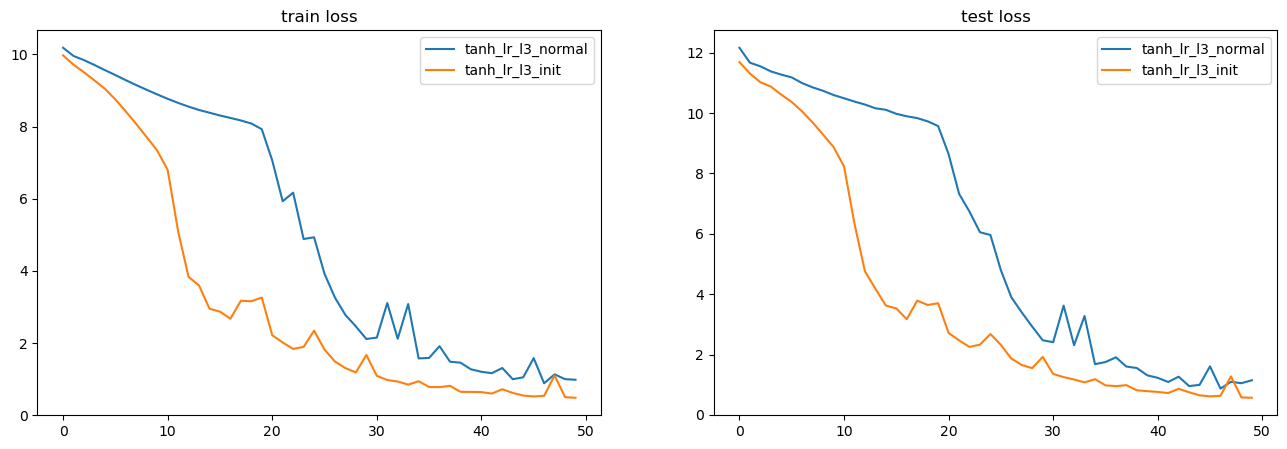

In [10]:
# 增加迭代次数
# 超参数
lr = 0.005
num_epochs = 50

# 重新实例化模型
tanh_lr_l3_normal = L3TanhLR()
tanh_lr_l3_init = L3TanhLR()

# 模型参数初始化
for module in tanh_lr_l3_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

# 模型列表
model_list = [tanh_lr_l3_normal, tanh_lr_l3_init]
name_list = ['tanh_lr_l3_normal', 'tanh_lr_l3_init']

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 经过初始化后，模型收敛速度更快，同时迭代多轮之后也更加稳定

### Xavier方法实现高斯分布的参数初始化
实现高斯分布的参数初始化，使用`nn.init.xavier_normal_`函数实现，标准差公式为：
$$\text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}$$

In [11]:
# 测试
weight = torch.randint(1, 21, (4, 4), dtype=torch.float)
print(weight)
nn.init.xavier_normal_(weight)  # 分母为4+4=8，所以std=sqrt(2/8)=0.5

tensor([[ 2., 12.,  9., 15.],
        [14.,  8., 20., 13.],
        [ 6.,  2.,  2.,  9.],
        [ 3., 16., 20., 14.]])


tensor([[ 3.2571e-01,  6.9665e-01, -6.6249e-01,  9.9242e-02],
        [ 6.8108e-01, -5.0277e-01,  1.0360e-01, -4.0641e-01],
        [ 6.3723e-04, -3.4652e-01,  5.7105e-01,  2.1544e-02],
        [ 3.2432e-01,  4.8954e-01, -1.6175e-01,  8.5230e-01]])

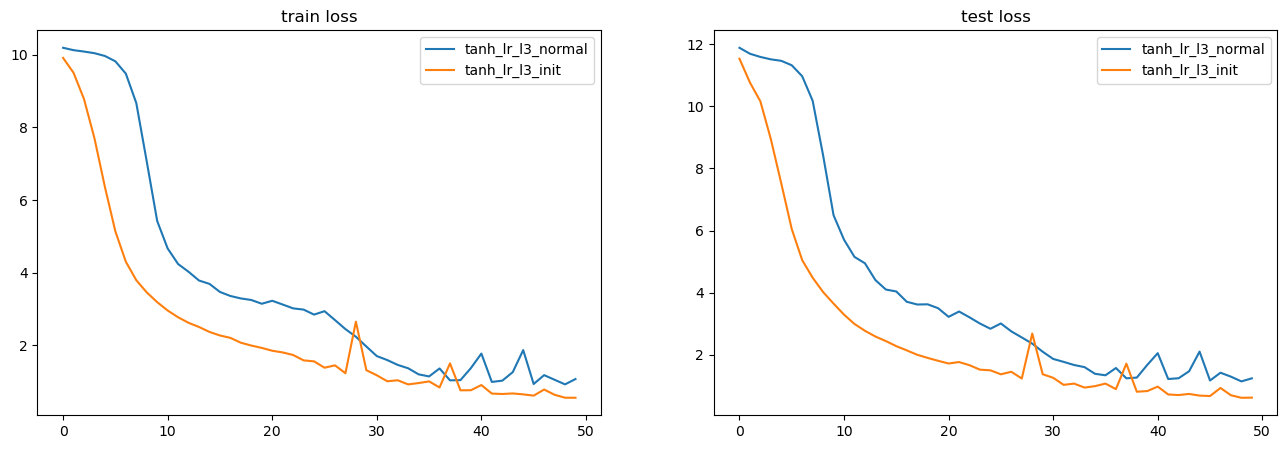

In [12]:
# 对Tanh模型进行测试
# 超参数
num_epochs = 50

# 重新实例化模型
tanh_lr_l3_normal = L3TanhLR()
tanh_lr_l3_init = L3TanhLR()

# 模型参数初始化
for module in tanh_lr_l3_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)

# 模型列表
model_list = [tanh_lr_l3_normal, tanh_lr_l3_init]
name_list = ['tanh_lr_l3_normal', 'tanh_lr_l3_init']

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 与均匀分布类似，经过正态分布的Xavier参数初始化的模型也加快了收敛速度，同时也更稳定

从理论上来说，均匀分布和高斯分布并没有根本性区别，二者任选其一使用即可。也有一些不是很严谨的实验证明了均匀分布比高斯分布能够产生相对较大的梯度，因而模型学习效果会更好。
## 2.Kaiming方法（HE初始化）
### He初始化基础
尽管Xavier初始化能够在Sigmoid和Tanh激活函数叠加的神经网络中起到一定的效果，但由于ReLU激活函数属于非饱和类激活函数，并不会出现类似Sigmoid和tanh激活函数使用过程中可能存在的梯度消失或梯度爆炸问题，反而因为ReLU激活函数的不饱和特性，ReLU激活函数的叠加极有可能出现神经元活性消失的问题，很明显该类问题无法通过Xavier初始化解决。尽管如此，通过参数初始值的合理设置，也能够实现保证模型的有效性，同时在一定程度上解决ReLU激活函数的神经元活性消失问题。目前通用的针对ReLU激活函数的初始化参数方法是由何凯明在2015年的[Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)一文中所提出的HE初始化方法，也被称为Kaiming方法。

He初始化也遵循Glorot条件，即参数初始化结果要求正向传播时各层接收到的数据方差保持一致、反向传播时各层参数梯度的方差保持一致，不过由于每一层的激活值（激活函数输出结果）均值不为0，因此Xavier的数学推导过程不再成立，但是经过HE初始化后仍然是规定参数是满足均值为0的随机变量，并且仍然借助均匀分布和高斯分布进行随机变量创建，HE初始化过程中，参数方差为$$Var(w)_{HE} = \frac{2}{fan_{in}} 或 Var(w)_{HE} = \frac{2}{fan_{out}}$$
即相对于Xavier方法的$Var(w)_{Xavier} = \frac{2}{fan_{in}+fan_{out}}$，Kaiming方法的方差分子不变，分母只取某层扇入或扇出的神经元的数量，同时被证明二者没有明显区别，任取其一即可。同时，HE初始化不仅针对ReLU激活函数，还适用于其各种变种激活函数。
根据参数方差，就能确定参数的实际分布（以$fan_{in}$为例）：
（1）如果假设w服从均匀在[-a, a]区间内均匀分布，则$bound = \sqrt{3var}$，因此参数分布区间为:$$(-\sqrt{\frac{6}{fan_{in}}}, \sqrt{\frac{6}{fan_{in}}})$$
（2）如果假设w是服从正态分布，则w是服从$(0, \sqrt{\frac{2}{fan_{in}}})$的随机变量。
### Kaiming方法实现均匀分布的参数初始化
实现均匀分布的参数初始化，使用`nn.init.kaiming_uniform_`函数实现，参数及其含义如下：
- mode：指定选择带入扇入还是扇出的神经元个数进行计算，理论上二者对建模没有明显影响，可任选其一，但实际由于模型个体差异，在实际使用过程中还是略有差异，可以根据实际效果进行选择
- a：使用ReLU变种激活函数时的修正系数
- nonlinearity：表示所选用的变种ReLU激活函数类型，需要配合a参数使用

边界计算公式为：
$$bound = \sqrt{\frac{6}{(1+a^2)fan_{in}}}$$
和Xavier方法一样，Kaiming方法直接对张量的值进行修改，并且张量列数表示$fan_{in}$的个数，行数表示$fan_{out}$的个数。

In [13]:
# 测试函数
weight = torch.randint(1, 21, (2, 6), dtype=torch.float)
print(weight)
nn.init.kaiming_uniform_(weight)  # 分母为6，所以bound=1，区间为(-1, 1)

tensor([[ 1.,  5.,  9.,  5., 17.,  5.],
        [ 9., 18.,  7.,  8., 18.,  1.]])


tensor([[-0.6186, -0.7436,  0.2849,  0.1733,  0.7935,  0.9237],
        [ 0.5903,  0.0574, -0.2967, -0.2261,  0.3096,  0.2406]])

In [14]:
# 测试函数：设置修正系数a
weight = torch.randint(1, 21, (2, 6), dtype=torch.float)
print(weight)
nn.init.kaiming_uniform_(weight, a=1)  # 分母为(1+1)*6=12，所以bound=sqrt(0.5)，区间大致为(-0.707, 0.707)

tensor([[ 6.,  3., 19.,  1.,  2.,  7.],
        [19.,  8., 10.,  9., 10., 19.]])


tensor([[ 0.1144, -0.5359, -0.5967, -0.1103, -0.6520,  0.2310],
        [-0.4090, -0.6888, -0.5888,  0.0161,  0.1783,  0.1653]])

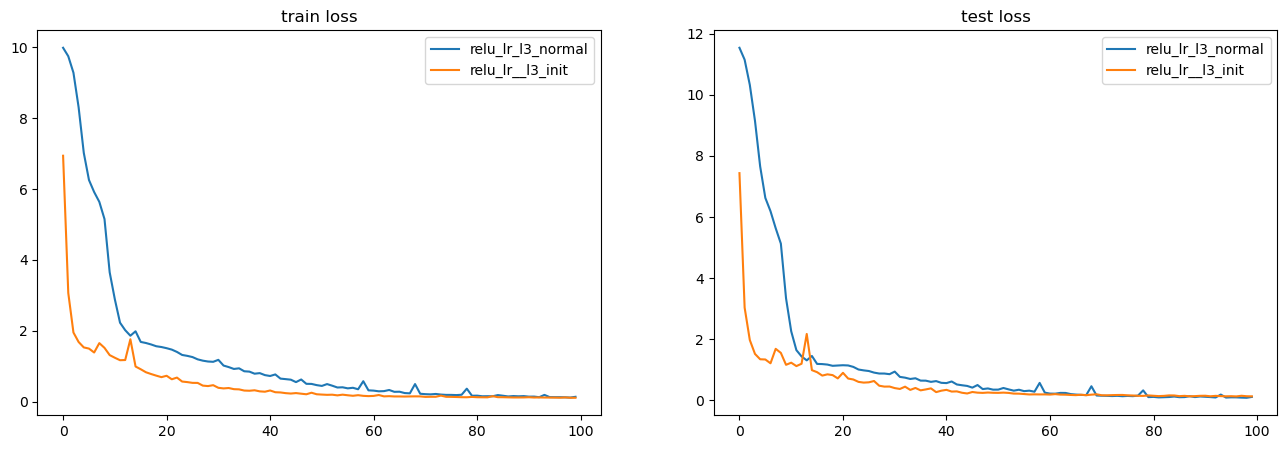

In [15]:
# Kaiming方法避免Dead ReLU Problem
# 设置超参数
lr = 5e-3  # 设置较小的学习率
num_epochs = 100

# 实例化模型
relu_lr_l3_normal = L3ReLULR()
relu_lr__l3_init = L3ReLULR()

# 模型参数Kaiming初始化
for module in relu_lr__l3_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)

# 模型列表
model_list = [relu_lr_l3_normal, relu_lr__l3_init]
name_list = ['relu_lr_l3_normal', 'relu_lr__l3_init']

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 经过均匀分布的Kaiming参数初始化的模型收敛更快

### Kaiming方法实现高斯分布的参数初始化
实现高斯分布的参数初始化，使用`nn.init.kaiming_normal_`函数实现，其方差计算公式为：
$$Var(w) = \frac{2}{(1+a^2)fan_{in}}$$
对应的标准差计算公式为：
$$std(w) = \sqrt{\frac{2}{(1+a^2)fan_{in}}}$$

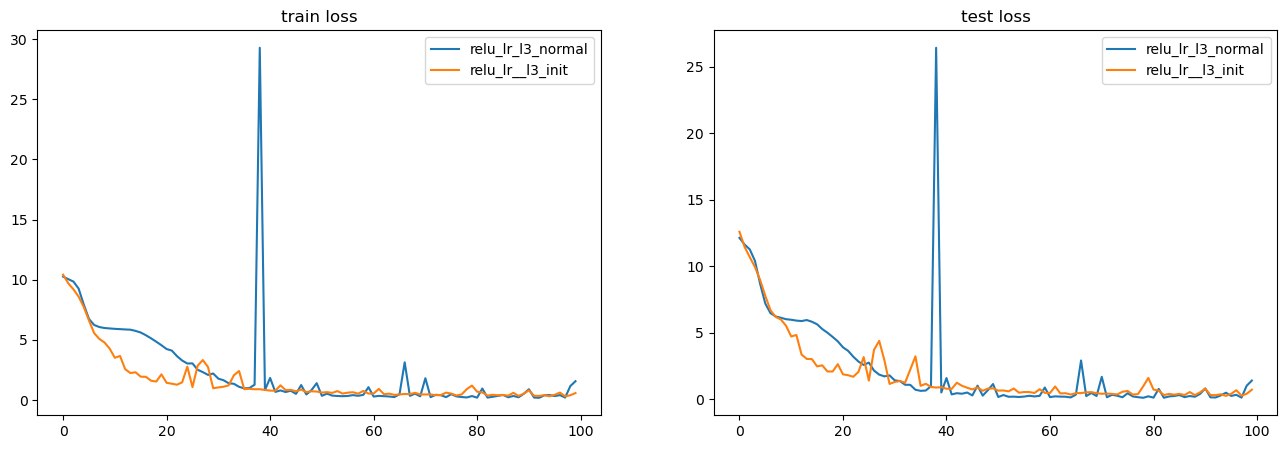

In [16]:
# 验证方法效果
# 设置超参数
num_epochs = 100

# 实例化模型
relu_lr_l3_normal = L3ReLULR()
relu_lr__l3_init = L3ReLULR()

# 模型参数Kaiming初始化
for module in relu_lr__l3_init.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)

# 模型列表
model_list = [relu_lr_l3_normal, relu_lr__l3_init]
name_list = ['relu_lr_l3_normal', 'relu_lr__l3_init']

# 迭代训练
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, lr=lr, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 与均匀分布类似，经过正态分布的Kaiming参数初始化的模型收敛速度更快，同时相对更加稳定

HE初始化之所以帮助模型规避Dead ReLU Problem，核心就在于模型初始化时如果参数完全随机选择，就有可能出现初始参数全部输出0的结果，而通过HE初始化的参数不会出现这样的情况。
## 3.参数初始化的作用局限性
合理的设置初始参数值能够一定程度上使得模型各层都得到有效的学习，模型训练过程更加平稳、收敛速度也更快。但由于我们设置的是初始条件，伴随着模型不断训练，由于受到激活函数导函数本身特性影响，仍然有可能在迭代过程中出现梯度不均衡和模型效果不稳定的现象（如上面的实验结果所示）。然而模型一旦开始训练，我们是不能人为干预和修改模型参数的（这样的话，模型训练本身就失去了意义）。影响梯度计算的三个核心因素，分别是**参数状态值**、**激活值**和**输入的数据**，参数状态值由模型迭代的数学过程决定，激活值很大程度上由选取的激活函数决定，如果从Glorot条件入手，就只剩下一个可以人工修改的选项，即每一个线性层接收到的数据。